### Simple ModelGrid Demo

This demo shows how the ModelGrid classes can work, where all model grid functionality is in the model grid class.  Only the geographic reference information and related methods remain in SpatialReference.

In [1]:
import os
import sys
import numpy as np
# run installed version of flopy or add local path
try:
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference

import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 18:42:56) 
[Clang 10.0.1 ]
numpy version: 1.18.5
matplotlib version: 3.2.2
flopy version: 3.3.3


Technically you need to create both a SpatialReference object and a ModelGrid object, but in practice the code looks very similar and can easily be implemented in one line.

In [2]:
mg = StructuredGrid(delc=np.ones(10), delr=np.ones(10), xoff=10, yoff=10, angrot=20, 
                    epsg=26715, lenuni=1)

### Transform, xcenters, xedges

Transform, xcenters, xedges behaves the same but is now a method of the ModelGrid, but has the same functionatily. 

In [3]:
mg.get_coords(10, 10)

(15.976724774602399, 22.81712764111577)

In [4]:
mg.get_local_coords(11.82170571129881, 13.906660505012088)

(3.0479999999999983, 3.048000000000002)

Methods to get cell centers of cells from the model grid are now in the ModelGrid classes.

In [5]:
mg.xcellcenters[1, 7] # x-coordinate at row 1, column 7

14.140523437626127

In [6]:
mg.xcellcenters[[1, 3], [7, 7]]

array([14.14052344, 14.82456372])

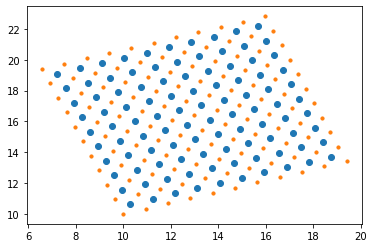

In [7]:
plt.scatter(mg.xcellcenters.ravel(), mg.ycellcenters.ravel())
plt.scatter(mg.xyzvertices[0].ravel(), mg.xyzvertices[1].ravel(), s=10)

### Model Coordinates

The model grid outputs everything in model coordinates if reference information is not given.

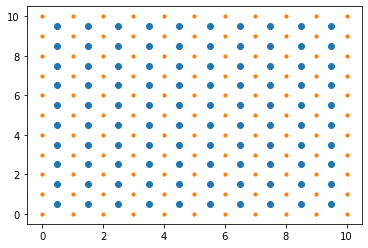

In [8]:
mg.set_coord_info()
plt.scatter(mg.xcellcenters.ravel(), mg.ycellcenters.ravel())
plt.scatter(mg.xyzvertices[0].ravel(), mg.xyzvertices[1].ravel(), s=10)

### Grid lines

In [9]:
def plot_lines(lines):
    fig, ax = plt.subplots()
    for ln in lines:
        plt.plot([ln[0][0], ln[1][0]], [ln[0][1], ln[1][1]])

(11.0, -1.0)

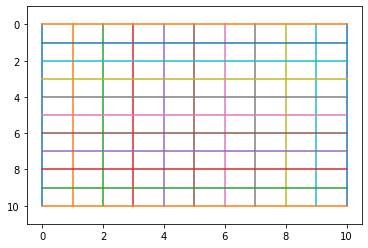

In [10]:
plot_lines(mg.grid_lines)
plt.ylim(11, -1)

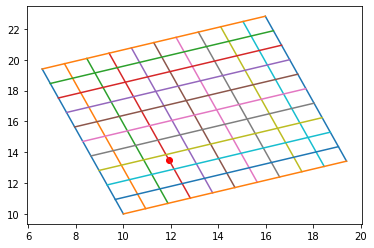

In [11]:
mg.set_coord_info(xoff=10, yoff=10, angrot=20, epsg=26715)
plot_lines(mg.grid_lines)
plt.scatter(11.9, 13.5, c='r')

### Vertices

In [12]:
mg.set_coord_info()
mg.xyzvertices[0]

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]])

In [13]:
mg.set_coord_info(xoff=10, yoff=10, angrot=20, epsg=26715)
mg.xyzvertices[0]

array([[ 6.57979857,  7.51949119,  8.45918381,  9.39887643, 10.33856905,
        11.27826167, 12.21795429, 13.15764691, 14.09733953, 15.03703215,
        15.97672477],
       [ 6.92181871,  7.86151133,  8.80120395,  9.74089657, 10.68058919,
        11.62028181, 12.55997443, 13.49966706, 14.43935968, 15.3790523 ,
        16.31874492],
       [ 7.26383885,  8.20353147,  9.14322409, 10.08291672, 11.02260934,
        11.96230196, 12.90199458, 13.8416872 , 14.78137982, 15.72107244,
        16.66076506],
       [ 7.605859  ,  8.54555162,  9.48524424, 10.42493686, 11.36462948,
        12.3043221 , 13.24401472, 14.18370734, 15.12339996, 16.06309258,
        17.0027852 ],
       [ 7.94787914,  8.88757176,  9.82726438, 10.766957  , 11.70664962,
        12.64634224, 13.58603486, 14.52572749, 15.46542011, 16.40511273,
        17.34480535],
       [ 8.28989928,  9.2295919 , 10.16928452, 11.10897715, 12.04866977,
        12.98836239, 13.92805501, 14.86774763, 15.80744025, 16.74713287,
        17.686

### Getting the Model Grid from the Model

In [14]:
ml = flopy.modflow.Modflow(modelname='new_model', exe_name='mf2005', 
                           version='mf2005', model_ws=os.path.join('data'))

dis = flopy.modflow.ModflowDis(ml,nlay=5,nrow=5,ncol=5,delr=[50,50,50,50,50],
                               delc=[50,50,50,50,50],top=0.0,botm=-50.0,laycbd=0) 

ibound = np.ones((5, 5, 5), dtype=int)
start = np.zeros((5, 5, 5), dtype=float)
bas = flopy.modflow.ModflowBas(ml,ibound=ibound,strt=start)

Use the .modelgrid attribute to get the model grid from the model. 

In [15]:
ml.modelgrid.xyzvertices[0]

array([[  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.]])

By default the flopy model class caches the model grid. If you later modify model discritization information the model grid can end up out of sync with the model discritization information.

In [16]:
dis.delr=[10,10,10,10,10]
ml.modelgrid.xyzvertices[0]

array([[  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.],
       [  0.,  50., 100., 150., 200., 250.]])

To resync the model grid with the latest model discritization information call update_modelgrid. Calling the update_modelgrid method clears the cached model grid and forces flopy to create a new model grid object on the next call to modelgrid. The current model discritization information is used to create the new model grid.

In [17]:
ml.update_modelgrid()
ml.modelgrid.xyzvertices[0]

array([[ 0., 10., 20., 30., 40., 50.],
       [ 0., 10., 20., 30., 40., 50.],
       [ 0., 10., 20., 30., 40., 50.],
       [ 0., 10., 20., 30., 40., 50.],
       [ 0., 10., 20., 30., 40., 50.],
       [ 0., 10., 20., 30., 40., 50.]])